### Accelerometer Frequency Analysis ###

This jupyter notebook is designed to accept a comma-separated (csv) list of timestamped accelerometer readings representing a recording of a vibrational phenomenon. While it is taylored to work with the output from the __[Physics Toolbox Sensor Suite app](https://www.vieyrasoftware.net/)__, we have tried to make the instructions here agnostic to the method of accelerometer recording used. In the sample data, we recorded the accelerometer while the phone rested on a clothes washer during its spin cycle. Using the discrete Fourier transform, we are able to determine how fast the washer spins.

#### The Input File Specification ####
What follows assumes that the input .csv file resembles:
```
time,ax,ay,az,aT
0.0030,0.0491,-0.0078,0.0529,0.073
0.0030,0.0864,0.0445,0.1711,0.197
0.0030,0.0834,0.0418,-0.1388,0.167
0.0040,-0.0311,0.0343,0.0404,0.061
0.0070,0.0522,-0.0039,0.1089,0.121
```

The ```time``` column has timestamps for each reading. Unlike the timestamps in the GPS data file, these are in units of seconds and represent the elapsed time of the recording. (This is an option in the recording app.)

The ```ax, ay,``` and ```az``` columns are accelerations along the $x$-, $y$-, and $z$-axes respectively. On my phone, the $x$-axis is parallel to width of the phone (the narrow direction), the $y$-axis is parallel to the length of the phone (the long direction), and the $z$-axis is perpendicular to the face of the phone. Your axes may be oriented differently. You can figure out your orientation by looking at the sensor graph in real time and strategically move the phone in different directions.

The ```aT``` column value is the magnitude of the acceleration vector ```<ax,ay,az>```. It is always positive and not terribly useful in this application.

_Sample Rate:_ a close look at the timestamps in the above snippet of data shows what appears to be 3 readings at the same time. In this exercise, we assume that the sample rate is constant. We approximate that rate as the ratio of the number of readings divided by the elapsed time. We are assuming that there is some bug or explicit programming challenge in getting the timestamps perfectly correct. The analysis that follows seems consistent with the constant sample rate assumption we use here.

__Note:__ There can be other columns present in the csv file, but in order for this notebook to function properly, these columns must be present with these column header names (case-sensitive) and these value specifications.

<div class="alert alert-block alert-info">
    <b>Author:</b> Albert Schueller <br>
    <b>Affiliation:</b> <a href="https://www.whitman.edu">Whitman College</a>, Walla Walla, WA USA <br>
    <b>License:</b> GNU General Public License v3.0
</div>


In [1]:
# Libraries needed by this notebook.
import pandas as pd
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt

#### Data Description: Analysis of clothes washer vibrations during spin cycle.

Accelerometer readings during spin cycle of a clothes washer. The washer front panel indicates a 1200RPM spin cycle. The data were measured using Physics Toolbox Sensor Suite Pro, on a OnePlus 3T phone, lying atop the washer, x-axis perpendicular to front of washer. The app/phone combination is capable of sampling forces at about 200Hz. At this sample rate, we are able to detect 1200RPM (60Hz) vibrations and higher, up to about 100Hz.

In [2]:
# Read the accelerometer data
raw = pd.read_csv('PSM Accelerometer Recording.csv')

In [3]:
# Total number of samples in recording
num_samples = raw.shape[0]

# Length of discrete Fourier transform window, seconds
l = 5

# Grab the sample times
t = np.array(raw.time)

# Grab the sample values, here we used the 'ay' data. Try changing to 'ax' or 'az', see which gives the best results.
a = np.array(raw.ay)

# Collect the discrete Fourier transforms at each times step in this list.
frequencies = []

# Modes to keep, e.g. since this device samples maximally at 200Hz, no point keeping more than 200 freqs for each window.
num_modes_to_keep = 100

# Compute discrete Fourier transforms in windows of length l, across the entire recording.
for p in range(0,num_samples):
    # break if too close to the end of the sample
    if t[-1]-p < l:
        break;
    # create l sec window mask
    w = (p<t) & (t<l+p)
    # do fft on the data in that window
    f = np.abs(fft(a[w]))
    # add f to list of frequencies
    frequencies.append(f[1:num_modes_to_keep])

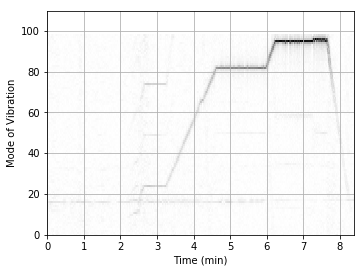

In [9]:
# Create a heat map of the discrete Fourier transforms as a function of window time.
fig, ax = plt.subplots(figsize=[5.5, 4.125])

ax.set_ylabel('Mode of Vibration')

### Uncomment these to convert to Hz. ###
#ax.set_ylabel('Frequency (Hz)')
#ax.set_yticks([i for i in range(0,num_modes_to_keep+10,10)])
#ax.set_yticklabels(["{:.1f}".format(i/l) for i in range(0,num_modes_to_keep+10,10)])

ax.set_xlabel('Time (min)')
ax.set_ylim((0,110))
ax.set_xticks([i for i in range(0,510,60)])
ax.set_xticklabels(["{:.0f}".format(i/60) for i in range(0,510,60)])
im = ax.imshow(np.transpose(frequencies),aspect='auto',origin='lower',cmap='gray_r')
ax.grid()
plt.show()

__Analysis:__ Each vertical slice of the heat map shows the amplitudes of the modes of vibration from 1 up to 100 at that moment in time. The spin cycle starts just after the 2nd minute. We see a plateau the lasts a minute where the dominant mode of vibration is around $n=25$. Since these windows are 5 seconds wide, we see that during this interval, the machine was vibrating 25 times every 5 seconds or 5Hz (300RPM). During the 3rd and 4th minutes, the spin accelerates and plateaus at about $n=82$. On this plateau, the washer is vibrating 82 times every 5 seconds or 16.4Hz (984RPM). The spin accelerates again and plateaus at about $n=95$ or 19Hz (1140RPM). This final value is close to the value of 1200RPM shown on the front of the machine.
![Washer 1200RPM](washer.jpg "Washer 1200RPM")

